<font color='red'>**Ciclo 7**</font>

**ENTENDER O PROBLEMA**

- Objetivo do Problema:
    - Previsão do primeiro destino que um novo usuario ira escolher.
    
    - Porque?
        - Qual o tipo de modelo de negocio do Airbnb?
        
            - Marketplace ( Conecta pessoas que oferecem acomodação, com pessoas que estão procurando acomodação )
            - Oferta ( pessoas oferecendo acomodação )
                - Tamanho do portfólio.
                - Diversidade/Densidade de Portifolio.
                - Preco Medio
                
            - Demanda ( pessoas procurando acomodação )
                - Numero de usuario
                - LTV ( Lifetime Value )
                - CAC ( Client Acquisition Cost )
                
                <font color='red'>**Receita Bruta**</font> =  ( Taxa*NúmeroDeClientes ) - CAC

             
             
- Proposta de Solução
    - Modelo de Previsão do primeiro destino de um novo usuario.
        - Predicoes e salva em uma tabela do banco de dados.
        - API
            - Input: Usuario e suas caracteristicas.
            - Output: Usuario e suas caracteristicas com a **predicao de destino** 
            

- Total de Ciclos ( CRISPM ):
    - 16 ciclos.
    

# IMPORTS

In [204]:
import pandas as pd
import numpy  as np

import matplotlib.pyplot as plt
import seaborn           as sns

from sklearn    import model_selection as ms
from sklearn    import preprocessing   as pp
from sklearn    import metrics         as m
from keras      import models          as ml
from keras      import layers          as l
from scikitplot import metrics         as mt
from scipy      import stats           as ss

from imblearn   import under_sampling  as us
from imblearn   import over_sampling   as oversamp
from imblearn   import combine         as c

from category_encoders import TargetEncoder

from pandas_profiling import ProfileReport

from IPython.display       import Image
from IPython.core.display  import HTML

#import random
from random import choices

import warnings
warnings.filterwarnings('ignore')

## Helper Functions

In [117]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )



def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Loading Data

In [118]:
df_raw = pd.read_csv('./data/training_users.csv', low_memory=True)
df_raw.shape

(213451, 16)

In [119]:
df_sessions = pd.read_csv('./data/sessions.csv', low_memory=True)
df_sessions.shape

#df_sessions[df_sessions['user_id'] == "00023iyk9l"][['user_id', 'action']].groupby('user_id').value_counts()

(10567737, 6)

# DATA DESCRIPTION

In [120]:
df1 = df_raw
df1.shape

(213451, 16)

## Data Dimensions 

In [121]:
print(f'number of rows: {df1.shape[0]}')
print(f'number of columns: {df1.shape[1]}')

number of rows: 213451
number of columns: 16


In [122]:
print(f'number of rows: {df_sessions.shape[0]}')
print(f'number of columns: {df_sessions.shape[1]}')

number of rows: 10567737
number of columns: 6


## Data Types

In [123]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [124]:
df_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## NA Check

In [125]:
df1.isna().sum() / len(df1)

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [126]:
df_sessions.isna().sum() / len(df_sessions)

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

In [127]:
# ================ Users ====================

# date_first_booking
date_first_booking_max = pd.to_datetime(df1['date_first_booking']).max().strftime('%Y-%m-%d')
df1['date_first_booking'] = df1['date_first_booking'].fillna(date_first_booking_max)

# age
df1 = df1[(df1['age'] > 15) & (df1['age'] < 120)]
avg_age = age = df1['age'].mean().astype(int)
df1['age'] = df1['age'].fillna(avg_age)

# first_affiliate_tracked
df1 = df1[~df1['first_affiliate_tracked'].isna()]

# ================ Sessions ====================

# user_id - 0.3%
df_sessions = df_sessions[~df_sessions['user_id'].isna()]


# action - 0.7%
df_sessions = df_sessions[~df_sessions['action'].isna()]


# action_type - 11%
df_sessions = df_sessions[~df_sessions['action_type'].isna()]


# action_detail - 11%
df_sessions = df_sessions[~df_sessions['action_detail'].isna()]


# secs_elapsed - 1.2%
df_sessions = df_sessions[~df_sessions['secs_elapsed'].isna()]


## Change Data Type

In [128]:
# date_account_created
df1['date_account_created'] = pd.to_datetime(df1['date_account_created'])

# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'], format='%Y%m%d%H%M%S')

# date_first_booking
df1['date_first_booking'] = pd.to_datetime(df1['date_first_booking'])

# age
df1['age'] = df1['age'].astype(int)

In [129]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## Check Balanced Data

In [130]:
df1['country_destination'].value_counts(normalize=True)

NDF      0.447275
US       0.391867
other    0.061246
FR       0.029918
IT       0.016423
GB       0.014335
ES       0.013740
CA       0.008676
DE       0.006858
NL       0.004852
AU       0.003531
PT       0.001280
Name: country_destination, dtype: float64

## Descriptive Analysis

## General

In [131]:
# users
num_attrs = df1.select_dtypes(include=['int64', 'float64'])
cat_attrs = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
time_attrs = df1.select_dtypes(include=['datetime64[ns]'])

# sessions
num_attrs_sessions = df_sessions.select_dtypes(include=['int64', 'float64'])
cat_attrs_sessions = df_sessions.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
time_attrs_sessions = df_sessions.select_dtypes(include=['datetime64[ns]'])

### Numerical - Users

In [132]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attrs.apply(np.mean)).T
ct2 = pd.DataFrame(num_attrs.apply(np.median)).T

# dispersions - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attrs.apply(np.std)).T
d2 = pd.DataFrame(num_attrs.apply(min)).T
d3 = pd.DataFrame(num_attrs.apply(max)).T
d4 = pd.DataFrame(num_attrs.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attrs.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attrs.apply(lambda x: x.kurtosis())).T

# concat
ct = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,16.0,115.0,99.0,37.405591,34.0,13.939844,2.089718,6.516468
1,signup_flow,0.0,25.0,25.0,2.519513,0.0,6.604696,2.705871,5.928298


### Numerical - Sessions

In [133]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attrs_sessions.apply(np.mean)).T
ct2 = pd.DataFrame(num_attrs_sessions.apply(np.median)).T

# dispersions - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attrs_sessions.apply(np.std)).T
d2 = pd.DataFrame(num_attrs_sessions.apply(min)).T
d3 = pd.DataFrame(num_attrs_sessions.apply(max)).T
d4 = pd.DataFrame(num_attrs_sessions.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attrs_sessions.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attrs_sessions.apply(lambda x: x.kurtosis())).T

# concat
ct = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,secs_elapsed,0.0,1799977.0,1799977.0,19961.8251,1369.0,88849.388449,11.137761,154.84312


### Categorical - Users

In [134]:
cat_attrs.drop('id', axis=1).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,122636,122636,122636,122636,122636,122636,122636,122636,122636,122636
unique,4,3,25,8,17,7,4,9,41,12
top,FEMALE,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,56362,66039,118205,79093,78954,64712,108283,57943,41778,54852


### Categorical - Sessions

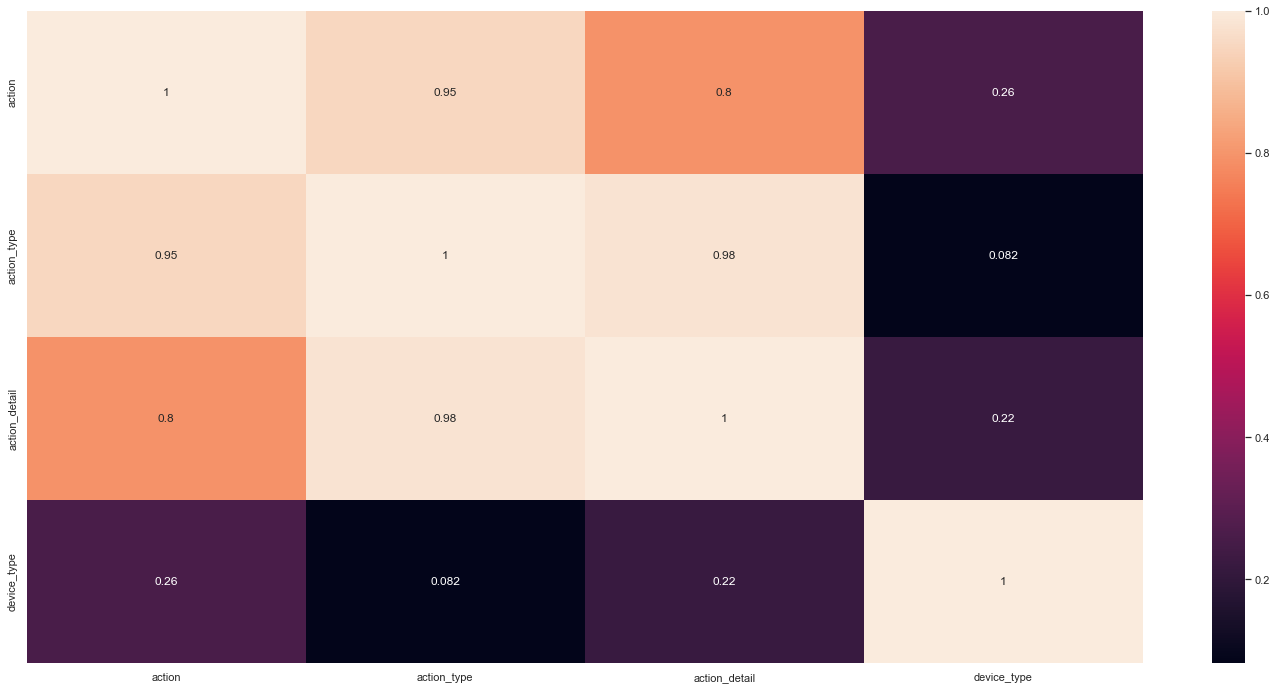

In [135]:
cat_attrs_sessions_list = cat_attrs_sessions.drop('user_id', axis=1).columns.tolist()

corr_dict = {}
for i in range(len(cat_attrs_sessions_list)):
    corr_list = []
    for j in range(len(cat_attrs_sessions_list)):
        
        ref = cat_attrs_sessions_list[i]
        feat = cat_attrs_sessions_list[j]
        
        # correlation
        corr = cramer_v(cat_attrs_sessions[ ref ], cat_attrs_sessions[ feat ])
        
        # append a list
        corr_list.append(corr)
        
    # append a correlation list for each ref attrs
    corr_dict[ref] = corr_list
    
d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns)
sns.heatmap(d, annot=True);

# FEATURE ENGINEERING

In [136]:
df2 = df1.copy()
df2.shape

(122636, 16)

## Create New Features

In [137]:
# days from first active up to frist booking
df2['first_active'] = pd.to_datetime(df2['timestamp_first_active'].dt.strftime('%Y-%m-%d'))
df2['days_from_first_active_until_booking'] = (df2['date_first_booking'] - df2['first_active']).apply(lambda x: x.days)

# days from first active up to account created
df2['days_from_first_active_account_created'] = (df2['date_account_created'] - df2['first_active']).apply(lambda x: x.days)

# days from account created up to first booking
df2['days_from_account_created_until_first_booking'] = (df2['date_first_booking'] - df2['date_account_created']).apply(lambda x: x.days)


# ========================== First Active ==========================


# year first active - ok
df2['year_first_active'] = df2['first_active'].dt.year

# month first active - ok
df2['month_first_active'] = df2['first_active'].dt.month

# day of first active - ok
df2['day_first_active'] = df2['first_active'].dt.day

# day of week first active - ok
df2['day_of_week_first_active'] = df2['first_active'].dt.dayofweek

# week of year first active - ok
df2['week_of_year_first_active'] = df2['first_active'].dt.weekofyear


# ========================== First Booking ==========================

# year first booking
df2['year_first_booking'] = df2['date_first_booking'].dt.year

# month first booking
df2['month_first_booking'] = df2['date_first_booking'].dt.month

# day of first booking
df2['day_first_booking'] = df2['date_first_booking'].dt.day

# day of week first booking
df2['day_of_week_first_booking'] = df2['date_first_booking'].dt.dayofweek

# week of year first booking
df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear

# ========================== First Account Created ==========================
 
# year first account created
df2['year_account_created'] = df2['date_account_created'].dt.year

# month first booking
df2['month_account_created'] = df2['date_account_created'].dt.month

# day of first booking
df2['day_account_created'] = df2['date_account_created'].dt.day

# day of week first booking
df2['day_of_week_account_created'] = df2['date_account_created'].dt.dayofweek

# week of year first booking
df2['week_of_year_account_created'] = df2['date_account_created'].dt.weekofyear


# DATA FILTERING

In [138]:
df3 = df2.copy()
df3.shape

(122636, 35)

## Filtering Rows

In [139]:
df3 = df3[(df3['age'] > 15) & (df3['age'] < 120)]

## Columns Selection

In [140]:
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking', 'first_active'] # origial dates

# BALANCED DATASET

In [141]:
df4 = df3.drop(cols_drop, axis=1)

In [142]:
# Encoder Categorical Variables
ohe = pp.OneHotEncoder()

# Numerical
col_num = df4.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Categorical
col_cat = df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']).drop(['id', 'country_destination'], axis=1).columns.tolist()

# encoding
df4_dummy = pd.DataFrame(ohe.fit_transform(df4[col_cat]).toarray(), index=df4.index)

# join numerical and categorical
df42 = pd.concat([df4[col_num], df4_dummy], axis=1)

## Random Undersampling

In [143]:
# ration balanced
ratio_balanced = {'NDF': 10000}

# define Sampler
undersampling = us.RandomUnderSampler(sampling_strategy=ratio_balanced, random_state=32)

# apply sampler
x_under, y_under = undersampling.fit_resample(df42, df4['country_destination'])

In [144]:
df4['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [145]:
y_under.value_counts()

US       48057
NDF      10000
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

## Random Oversampling

In [146]:
# define Sampler
oversampling = oversamp.RandomOverSampler(sampling_strategy='all', random_state=32)

# apply sampler
x_over, y_over = oversampling.fit_resample(df42, df4['country_destination'])

In [147]:
df4['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [148]:
y_over.value_counts()

NDF      54852
US       54852
other    54852
CA       54852
FR       54852
IT       54852
ES       54852
GB       54852
NL       54852
DE       54852
AU       54852
PT       54852
Name: country_destination, dtype: int64

## SMOTE + TOMELINK

In [149]:
ratio_balanced = {
    
    'NDF': 54852,
    'US': 48057,
    'other': 6*7511,
    'FR': 12*3669,
    'IT': 20*2014,
    'GB': 30*1758,
    'ES': 30*1685,
    'CA': 40*1064,
    'DE': 45*841,
    'NL': 80*595,
    'AU': 85*433,
    'PT': 300*157
}

<font color='red'>**ARRUMAR ACCOUNTED CREATED**</font>

In [150]:
# # define sampler
# smt = c.SMOTETomek(sampling_strategy=ratio_balanced, random_state=32, n_jobs=1)

# # apply sampler
# x_smt, y_smt = smt.fit_resample(df42, df4['country_destination'])

# # numerical data
# df43 = x_smt[col_num]

# # =-=-=-=-==-=-=-=-==-=-=-=-==-=-=-=-==-=-=-=-==-=-=-=-==-=-=-=-==-=-=-=-==-=-=-=-==-=-=-=-=

# # categorical data
# df44 = x_smt.drop(col_num, axis=1)
# df45 = pd.DataFrame(ohe.inverse_transform(df44), columns=col_cat, index=df44.index)

# # join numerical categorical
# df46 = pd.concat([df43, df45], axis=1)
# df46['country_destination'] = y_smt

# df46.to_csv('./data/df46.csv', index=False)

# =-=-=-=-==-=-=-=-==-=-=-=-==-=-=-=-==-=-=-=-==-=-=-=-==-=-=-=-==-=-=-=-==-=-=-=-==-=-=-=-=

df46 = pd.read_csv('./data/df46.csv')

# EXPLORATORY DATA ANALYSIS

## Hypothesis Validation (Unbalanced Dataset)

In [151]:
df51 = df4.copy()

**H01**. Em todos os destinos, os usuarios levam 15 dias, em media, para fazer a primeira reserva no AirBnB, desde sua primeira ativação.

**VERDADEIRO**. Em todos os destinos os usuarios levam até 6 dias para reservar.

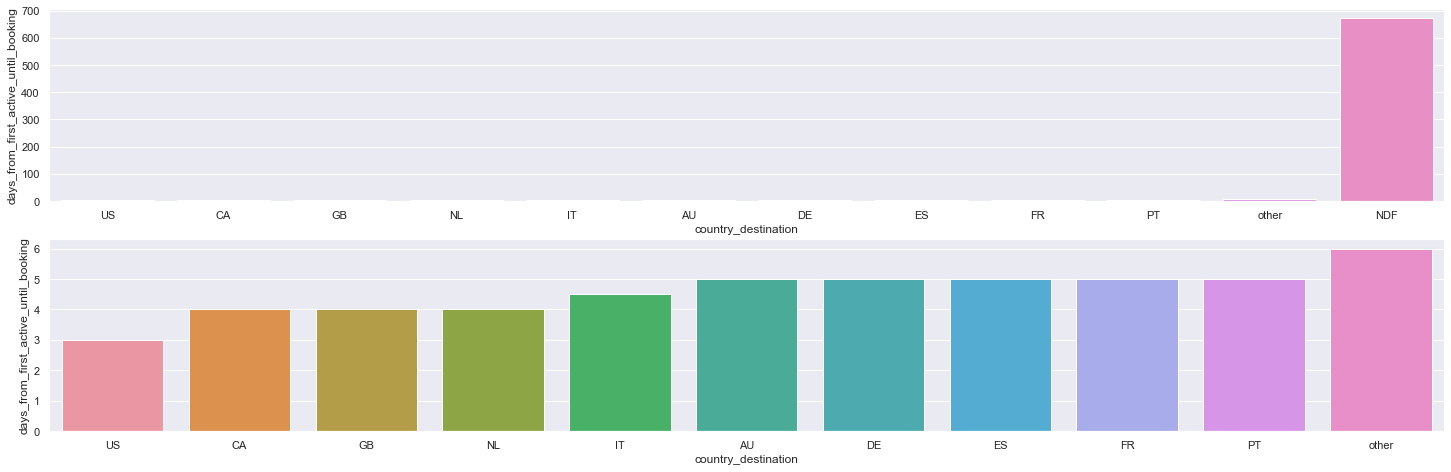

In [152]:
plt.subplot(3, 1, 1)

aux01 = df51[['days_from_first_active_until_booking', 'country_destination']].groupby('country_destination').median().reset_index()
sns.barplot(x='country_destination', y='days_from_first_active_until_booking', data=aux01.sort_values('days_from_first_active_until_booking'));

# remove outlier

plt.subplot(3, 1, 2)

aux02 = df51[df51['country_destination'] != 'NDF']
aux02 = aux02[['days_from_first_active_until_booking', 'country_destination']].groupby('country_destination').median().reset_index()
sns.barplot(x='country_destination', y='days_from_first_active_until_booking', data=aux02.sort_values('days_from_first_active_until_booking'));

**H02**. Em todos os destinos, os usuarios levam 3 dias em media para fazer o cadastro no site

**VERDADEIRA** Em todos os destinos os usuarios levam até 2 dias para finalizar o cadastro.

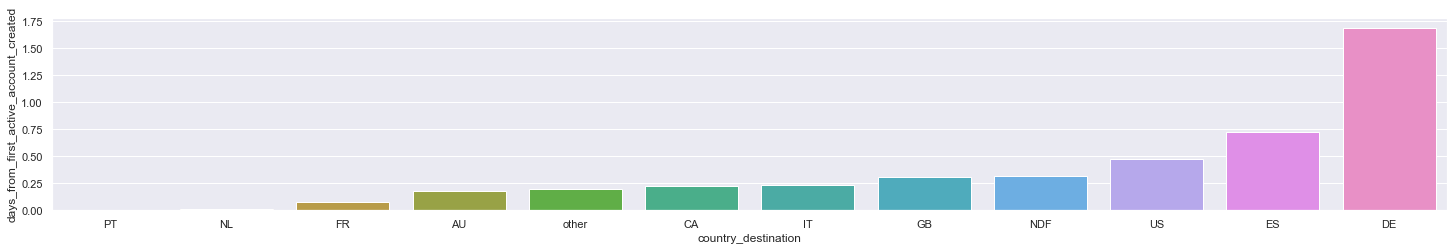

In [153]:
plt.subplot(3, 1, 1)

aux01 = df51[['days_from_first_active_account_created', 'country_destination']].groupby('country_destination').mean().reset_index()
sns.barplot(x='country_destination', y='days_from_first_active_account_created', data=aux01.sort_values('days_from_first_active_account_created'));

**H03**. O volume de reservas anual feitas durante o verão aumentaram 20% para destinos dentro dos USA.

**FALSA** O Volume de reservas aumentam durante o verao entre os anos de 2010 até 2013.

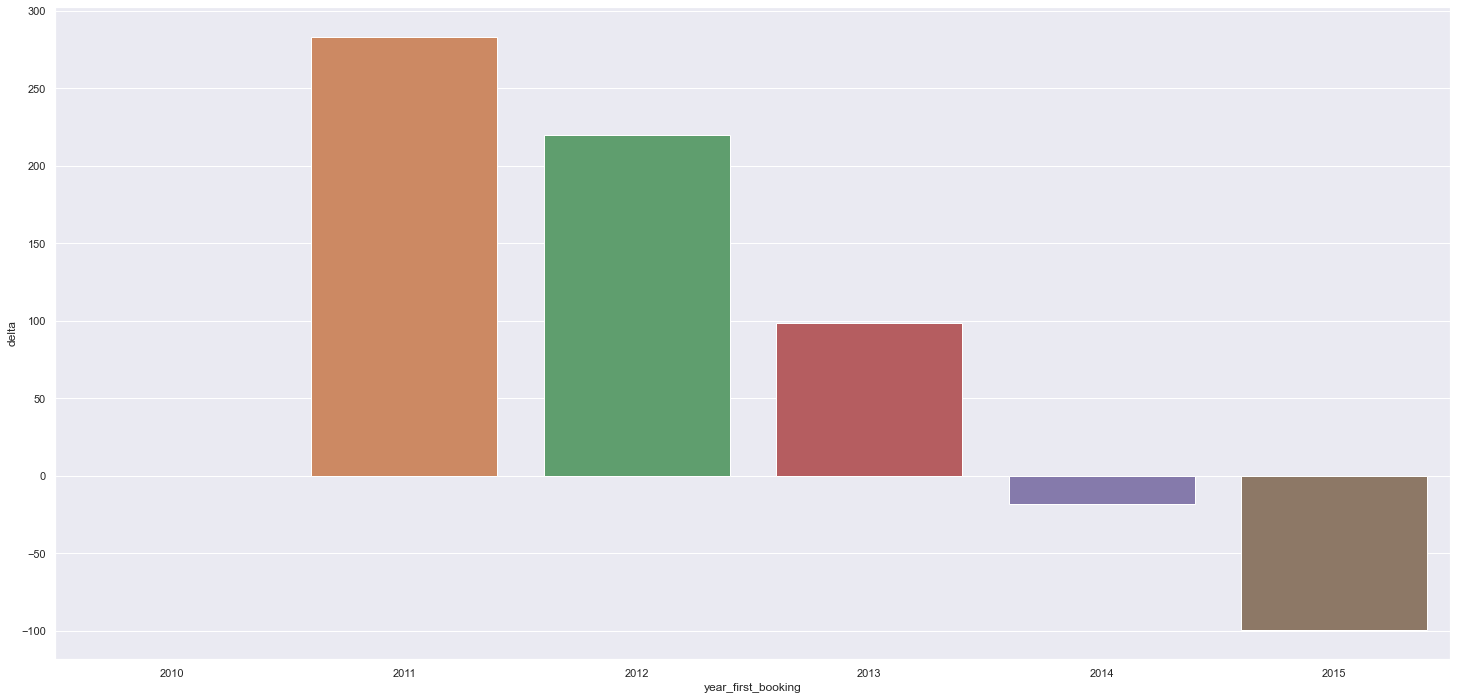

In [154]:
aux01 = df52[['year_first_booking','month_first_booking','country_destination']]\
.groupby(['year_first_booking','month_first_booking','country_destination']).size().reset_index().rename(columns={0:'count'})

# select only summer
aux01 = aux01[(aux01['month_first_booking'].isin([6, 7, 8, 9]) & (aux01['country_destination'] == 'US'))]

aux02 = aux01[['year_first_booking', 'count']].groupby('year_first_booking').sum().reset_index()
aux02['delta'] = 100*aux02['count'].pct_change().fillna(0)

sns.barplot(x='year_first_booking', y='delta', data=aux02);

**H04**. Usuarios do sexo feminino fazem 10% mais reservas para paises fora dos USA,

**H05**. O canal de marketing Google representa 40% das reservas para paises fora dos USA.

**H06**. O destino dos USA representam mais de 20% em todos os canais.

**H07**. A idade media das pessoas é de 35 anos em todos os destinos

**H08**. A porcentagem de usuarios que usam o site na lingua ingle-americano para reservar acomodações em qualquer destino é maior que 90%

**H09**. O número de reservas do AirBnB é crescente ou decrescente ao longo dos anos?

**H10**. O numero de reservas do AirBnB é crescente ao longo dos ano.

## Variables Impact (Balanced Dataset)

In [155]:
df52 = df4.copy()

In [156]:
# profile = ProfileReport(df51) 
# profile.to_notebook_iframe()  

In [157]:
# =================================== High Correlation ===================================
# days_from_first_active_until_booking x days_from_account_created_until_first_booking
# remove: days_from_first_active_until_booking

# year_first_active x year_account_created
# remove: year_first_active 

# month_first_active x month_account_created
# remove: month_first_active

# day_first_active x day_account_created
# remove: day_first_acrtive

# day_of_yeek_first_active x day_of_yeek_account_created
# remove: day_of_yeek_first_active

# week_of_year_first_active x week_of_year_account_created
# remove: week_of_year_first_active

# month_first_booking x week_of_year_account_created
# remove: month_first_booking

# month_account_created x week_of_year_account_created
# remove: month_account_created

# year_first_booking x year_account_created
# remove: year_first_booking

# week_of_year_first_booking x week_of_year_account_created
# remove: week_of_year_first_booking

# affiliate_channel x affiliate_provider
# remove: affiliate_provider

# first_device_type x first_browser
# remove: first_browser

# first_device_type x sigup_app
# remove: first_device_type

### Univariate Analysis

### Bivariate Analysis

### Multivariate Analysis

In [163]:
cols = ['days_from_first_active_until_booking', 'year_first_active', 'month_first_active', 'day_first_active', 'day_of_week_first_active', 'week_of_year_first_active',
       'month_first_booking', 'month_account_created', 'year_first_booking', 'week_of_year_first_booking', 'affiliate_provider', 'first_browser', 'first_device_type', 'language']

# DATA PREPARATION

In [191]:
df6 = df46.drop(cols, axis=1)
df6.shape

(546297, 16)

In [192]:
df6.dtypes

age                                               int64
signup_flow                                       int64
days_from_first_active_account_created            int64
days_from_account_created_until_first_booking     int64
day_first_booking                                 int64
day_of_week_first_booking                         int64
year_account_created                              int64
day_account_created                               int64
day_of_week_account_created                       int64
week_of_year_account_created                      int64
gender                                           object
signup_method                                    object
affiliate_channel                                object
first_affiliate_tracked                          object
signup_app                                       object
country_destination                              object
dtype: object

## Rescaling

In [193]:
ss = pp.StandardScaler()
rs = pp.RobustScaler()
mms = pp.MinMaxScaler()

In [194]:
# age - standardization
df6['age'] = ss.fit_transform(df6[['age']].values)

# sigup_flow - robust scaler
df6['sigup_flow'] = rs.fit_transform(df6[['signup_flow']].values)

# days_from_first_active_account_created - robust scaler
df6['days_from_first_active_account_created'] = rs.fit_transform(df6[['days_from_first_active_account_created']].values)

# days_from_account_created_until_first_booking - robust scaler
df6['days_from_account_created_until_first_booking'] = rs.fit_transform(df6[['days_from_account_created_until_first_booking']].values)

# year_account_created - minmax scaler
df6['year_account_created'] = mms.fit_transform(df6[['year_account_created']].values)


## Encoding

In [195]:
te = TargetEncoder()

In [196]:
# gender - OneHotEncoder
df6 = pd.get_dummies(df6, prefix=['gender'], columns=['gender'])

# signup_method - OneHotEncoder
df6 = pd.get_dummies(df6, prefix=['signup_method'], columns=['signup_method'])

# signup_app - OneHotEncoder
df6 = pd.get_dummies(df6, prefix=['signup_app'], columns=['signup_app'])

# affiliate_channel - TargetEncoder
c = {'NDF': 0, 'US': 1, 'other': 2, 'CA': 3, 'FR': 4, 'IT': 5, 'ES': 6, 'GB': 7, 'NL': 8, 'DE': 9, 'AU': 10, 'PT': 11}
df6['affiliate_channel'] = te.fit_transform(df6[['affiliate_channel']].values, df6['country_destination'].map(c))

# first_affiliate_tracked - TargetEncoder
df6['first_affiliate_tracked'] = te.fit_transform(df6[['first_affiliate_tracked']].values, df6['country_destination'].map(c))

In [197]:
df6.head()

,age,signup_flow,days_from_first_active_account_created,days_from_account_created_until_first_booking,day_first_booking,day_of_week_first_booking,year_account_created,day_account_created,day_of_week_account_created,week_of_year_account_created,affiliate_channel,first_affiliate_tracked,country_destination,sigup_flow,gender_-unknown-,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,signup_method_facebook,signup_method_google,signup_app_Android,signup_app_Moweb,signup_app_Web,signup_app_iOS
0,0.092423,0,732.0,14.466019,29,0,0.25,25,2,21,5.273801,5.387647,NDF,0.0,0,0,1,0,0,1,0,0,0,1,0
1,1.456545,3,476.0,-0.611650,2,0,0.00,28,1,39,5.359326,5.387647,US,3.0,0,1,0,0,1,0,0,0,0,1,0
2,0.395561,0,765.0,2.640777,8,5,0.25,5,0,49,5.359326,5.387647,other,0.0,0,1,0,0,0,1,0,0,0,1,0
3,0.319777,0,280.0,-2.077670,18,3,0.00,14,1,37,5.359326,5.387647,US,0.0,1,0,0,0,1,0,0,0,0,1,0
4,0.698700,0,0.0,-0.029126,5,1,0.00,2,5,53,4.531574,5.387647,US,0.0,0,1,0,0,1,0,0,0,0,1,0


## Transformation

In [198]:
# week_of_year_account_created
df6['week_of_year_account_created_sin'] = df6['week_of_year_account_created'].apply(lambda x: np.sin(x * ( 2*np.pi/52 )))
df6['week_of_year_account_created_cos'] = df6['week_of_year_account_created'].apply(lambda x: np.sin(x * ( 2*np.pi/52 )))

# day_of_week_first_booking
df6['day_of_week_first_booking_sin'] = df6['day_of_week_first_booking'].apply(lambda x: np.sin(x * ( 2*np.pi/7 )))
df6['day_of_week_first_booking_cos'] = df6['day_of_week_first_booking'].apply(lambda x: np.sin(x * ( 2*np.pi/7 )))

# day_account_created
df6['day_account_created_sin'] = df6['day_account_created'].apply(lambda x: np.sin(x * ( 2*np.pi/31 )))
df6['day_account_created_cos'] = df6['day_account_created'].apply(lambda x: np.sin(x * ( 2*np.pi/31 )))

# day_of_week_account_created
df6['day_of_week_account_created_sin'] = df6['day_of_week_account_created'].apply(lambda x: np.sin(x * ( 2*np.pi/7 )))
df6['day_of_week_account_created_cos'] = df6['day_of_week_account_created'].apply(lambda x: np.sin(x * ( 2*np.pi/7 )))

# FEATURE SELECTION

In [200]:
df7 = df6.copy()

In [201]:
X = df7.drop('country_destination', axis=1)
y = df7['country_destination'].copy()

In [202]:
# split dataset into training and test
x_train, x_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32)

# MACHINE LEARNING MODEL

## Baseline Model

In [210]:
country_destination_list = df1['country_destination'].drop_duplicates().sort_values().tolist()
k_num = y_test.shape[0]
country_destination__weights = df1['country_destination'].value_counts(normalize=True).sort_index().to_list()

yhat_random = choices(population=country_destination_list, 
                               weights=country_destination__weights,
                               k=k_num)
len(yhat_random)

109260

## Baseline Model Perfomance

Accuracy: 0.09253157605711147
Balanced Accuracy: 0.08362005963710384
Kappa Score: 0.00033400092337143583
              precision    recall  f1-score   support

          AU       0.06      0.00      0.01      7335
          CA       0.07      0.01      0.01      8536
          DE       0.08      0.01      0.01      7463
          ES       0.10      0.01      0.03     10026
          FR       0.08      0.03      0.04      8817
          GB       0.11      0.02      0.03     10546
          IT       0.08      0.02      0.03      8076
         NDF       0.10      0.45      0.16     10938
          NL       0.07      0.00      0.01      9549
          PT       0.09      0.00      0.00      9481
          US       0.09      0.39      0.14      9557
       other       0.08      0.06      0.07      8936

    accuracy                           0.09    109260
   macro avg       0.08      0.08      0.05    109260
weighted avg       0.08      0.09      0.05    109260



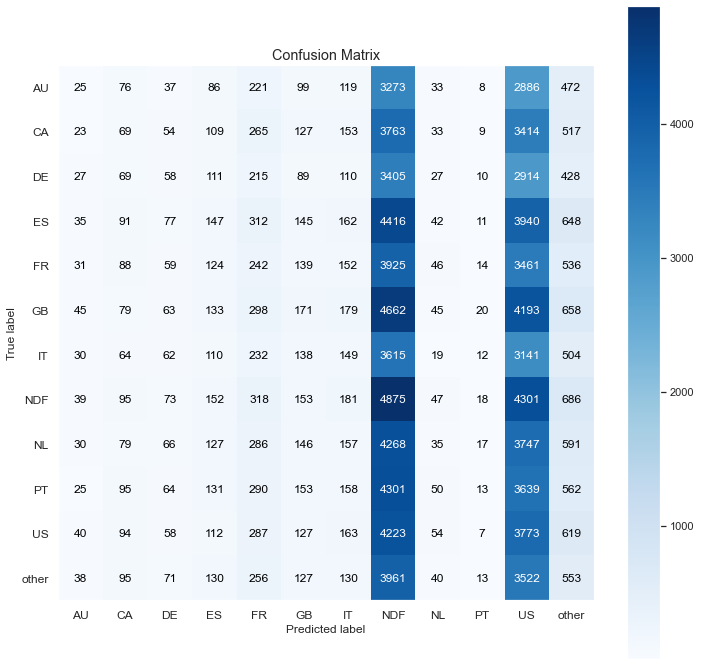

In [211]:
# Accuracy
acc_random = m.accuracy_score(y_test, yhat_random)
print(f'Accuracy: {acc_random}')

# Balanced Accuracy
balanced_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
print(f'Balanced Accuracy: {balanced_acc_random}')

# Kappa Metrics
kappa_random = m.cohen_kappa_score(y_test, yhat_random)
print(f'Kappa Score: {kappa_random}')

# Classification Report 
print(m.classification_report(y_test, yhat_random))

# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(12,12));

## Neural Network - MLP

In [212]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()

In [213]:
x_train.shape

(437037, 32)

In [214]:
# model definition
model = ml.Sequential()
model.add(l.Dense(64, input_dim=x_train.shape[1], activation='relu'))
model.add(l.Dense(12, activation='softmax'))

# model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train mode
model.fit(x_train, y_train_nn, epochs=100)

2022-07-08 09:48:26.495694: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-08 09:48:26.495737: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-08 09:48:26.495774: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kaka-desktop): /proc/driver/nvidia/version does not exist
2022-07-08 09:48:26.496539: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
13658/13658 [==============================] - 23s 2ms/step - loss: 2.1216 - accuracy: 0.2422
Epoch 2/100
13658/13658 [==============================] - 22s 2ms/step - loss: 2.0268 - accuracy: 0.2792
Epoch 3/100
13658/13658 [==============================] - 22s 2ms/step - loss: 1.9853 - accuracy: 0.2945
Epoch 4/100
13658/13658 [==============================] - 22s 2ms/step - loss: 1.9636 - accuracy: 0.3030
Epoch 5/100
13658/13658 [==============================] - 21s 2ms/step - loss: 1.9499 - accuracy: 0.3085
Epoch 6/100
13658/13658 [==============================] - 22s 2ms/step - loss: 1.9394 - accuracy: 0.3126
Epoch 7/100
13658/13658 [==============================] - 21s 2ms/step - loss: 1.9311 - accuracy: 0.3159
Epoch 8/100
13658/13658 [==============================] - 22s 2ms/step - loss: 1.9265 - accuracy: 0.3183
Epoch 9/100
13658/13658 [==============================] - 21s 2ms/step - loss: 1.9219 - accuracy: 0.3198
Epoch 10/100
13658/13658 [====================

13658/13658 [==============================] - 22s 2ms/step - loss: 1.8681 - accuracy: 0.3387
Epoch 78/100
13658/13658 [==============================] - 22s 2ms/step - loss: 1.8683 - accuracy: 0.3388
Epoch 79/100
13658/13658 [==============================] - 22s 2ms/step - loss: 1.8678 - accuracy: 0.3384
Epoch 80/100
13658/13658 [==============================] - 22s 2ms/step - loss: 1.8677 - accuracy: 0.3390
Epoch 81/100
13658/13658 [==============================] - 22s 2ms/step - loss: 1.8677 - accuracy: 0.3382
Epoch 82/100
13658/13658 [==============================] - 22s 2ms/step - loss: 1.8669 - accuracy: 0.3392
Epoch 83/100
13658/13658 [==============================] - 22s 2ms/step - loss: 1.8664 - accuracy: 0.3387
Epoch 84/100
13658/13658 [==============================] - 22s 2ms/step - loss: 1.8664 - accuracy: 0.3391
Epoch 85/100
13658/13658 [==============================] - 22s 2ms/step - loss: 1.8666 - accuracy: 0.3390
Epoch 86/100
13658/13658 [========================

## NEURAL NETWORK PERFORMANCE

In [215]:
# prediction
pred_nn = model.predict(x_test)

# invert prediction
yhat_nn = ohe.inverse_transform(pred_nn)

# prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1, -1)[0]

3415/3415 [==============================] - 4s 1ms/step


In [216]:
# Balanced Accuracy
m.balanced_accuracy_score(y_test_nn, yhat_nn)

0.3254390172318434

Accuracy: 0.3424858136555006
Balanced Accuracy: 0.3254390172318434
Kappa Score: 0.2806357301198774
              precision    recall  f1-score   support

          AU       0.29      0.38      0.33      7335
          CA       0.21      0.18      0.20      8536
          DE       0.24      0.12      0.16      7463
          ES       0.19      0.21      0.20     10026
          FR       0.15      0.08      0.10      8817
          GB       0.17      0.14      0.15     10546
          IT       0.17      0.06      0.09      8076
         NDF       1.00      1.00      1.00     10938
          NL       0.26      0.37      0.30      9549
          PT       0.48      0.93      0.64      9481
          US       0.24      0.38      0.30      9557
       other       0.16      0.06      0.09      8936

    accuracy                           0.34    109260
   macro avg       0.30      0.33      0.30    109260
weighted avg       0.31      0.34      0.31    109260



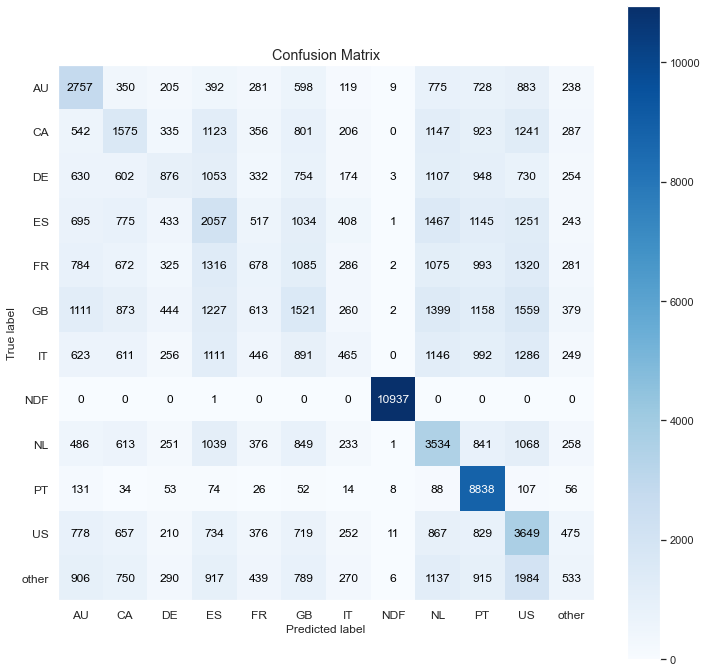

In [217]:
# Accuracy
acc_nn = m.accuracy_score(y_test_nn, yhat_nn)
print(f'Accuracy: {acc_nn}')

# Balanced Accuracy
balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
print(f'Balanced Accuracy: {balanced_acc_nn}')

# Kappa Metrics
kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print(f'Kappa Score: {kappa_nn}')

# Classification Report 
print(m.classification_report(y_test_nn, yhat_nn))

# Confusion Matrix
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(12,12));

### NEURAL NETWORK PERFORMANCE - Cross-Validation

In [ ]:
# generate k-fold
num_folds = 5
kfold = ms.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=32)

# create list

balanced_acc_list = []
kappa_acc_list = []

i = 1
for train_ix, val_ix in kfold.split(x_train, y_train):
    
    print(f'Folder Number: {i} / {num_folds}')
    
    # get fold
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    

    # target - hot-enconding
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform(y_train_fold.values.reshape(-1, 1)).toarray()
    
    # model definition
    model = ml.Sequential()
    model.add(l.Dense(256, input_dim=x_train.shape[1], activation='relu'))
    model.add(l.Dense(11, activation='softmax'))

    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # training model
    model.fit(x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0)

    # prediction
    pred_nn = model.predict(x_val_fold) #dados encoding
    yhat_nn = ohe.inverse_transform(pred_nn) # dados original
    
    # prepare data
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape(1, -1)[0]
    
    # metrics
    
    ## balanced accuracy
    balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
    balanced_acc_list.append(balanced_acc_nn)
    
    ## kappa metrics
    kappa_acc_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
    kappa_acc_list.append(kappa_acc_nn)
    
    i += 1

In [ ]:
print(f'Avg Balanced Accuracy: {np.mean(balanced_acc_list)} / {np.std(balanced_acc_list)}')
print(f'Avg Kapaa: {np.mean(kappa_acc_list)} / {np.std(kappa_acc_list)}')